In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import requests

In [ ]:
urls = [
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/AMAZON_FASHION_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/All_Beauty_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Appliances_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Automotive_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/CDs_and_Vinyl_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Clothing_Shoes_and_Jewelry_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Electronics_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Home_and_Kitchen_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Industrial_and_Scientific_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Kindle_Store_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Magazine_Subscriptions_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Movies_and_TV_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Musical_Instruments_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Office_Products_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Patio_Lawn_and_Garden_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Pet_Supplies_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Prime_Pantry_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Software_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Sports_and_Outdoors_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Tools_and_Home_Improvement_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Toys_and_Games_5.json.gz",
    "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz"
]


download_directory = "./Data/"

os.makedirs(download_directory, exist_ok=True)

for url in urls:

    filename = url.split("/")[-1]

    full_path = download_directory + filename
    response = requests.get(url)

    if response.status_code == 200:
        with open(full_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"Failed to download: {filename}")

Downloaded: AMAZON_FASHION_5.json.gz
Downloaded: All_Beauty_5.json.gz
Downloaded: Appliances_5.json.gz
Downloaded: Arts_Crafts_and_Sewing_5.json.gz
Downloaded: Automotive_5.json.gz
Downloaded: CDs_and_Vinyl_5.json.gz
Downloaded: Cell_Phones_and_Accessories_5.json.gz


In [3]:
data_folder = "Data/"
output_folder = "Dataset/"

os.makedirs(output_folder, exist_ok=True)

all_data = []

for filename in os.listdir(data_folder):
    if filename.endswith(".json.gz"):
        file_path = os.path.join(data_folder, filename)
        with gzip.open(file_path) as f:
            file_data = []
            for line_number, line in enumerate(f):
                if line_number >= 10000:
                    break
                try:
                    product_data = json.loads(line.strip())
                    review_text = product_data.get('reviewText')

                    if not isinstance(review_text, str):
                        print(f"Warning: 'reviewText' in line {line_number + 1} is not a string.")
                        continue

                    subset = {'reviewText': review_text, 'Overall': product_data.get('overall')}
                    file_data.append(subset)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in line {line_number + 1}: {e}")

            all_data.extend(file_data)

df = pd.DataFrame(all_data)

csv_filename = os.path.join(output_folder, "data.csv")
df.to_csv(csv_filename, index=False)

print(f"Processed all files, Total rows in DataFrame: {len(df)}")

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as pd
import os

class AmazonReviewsDataset(Dataset):
    def __init__(self, csv_filepath, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dataframes = pd.read_csv(csv_filepath)

    def __len__(self):
        return len(self.dataframes)

    def __getitem__(self, idx):
        df = self.dataframes.loc[idx]
        texts = df['reviewText']
        labels = df['Overall']

        encoding = self.tokenizer(texts, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': torch.tensor(labels)}

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# csv_folder = "Dataset/data.csv"
# amazon_dataset = AmazonReviewsDataset(csv_folder, tokenizer, max_length=256)

# def collate_fn(batch):
#     input_ids = torch.stack([item['input_ids'] for item in batch], dim=0)
#     attention_mask = torch.stack([item['attention_mask'] for item in batch], dim=0)
#     labels = torch.stack([item['labels'] for item in batch], dim=0)
#     return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


# dataloader = DataLoader(amazon_dataset, batch_size=32, shuffle=True)

In [ ]:
# amazon_dataset.__getitem__(10)

for batch in dataloader:
    print(batch['input_ids'])
    print(batch['attention_mask'])
    print(batch['labels'])
    break

tensor([[  101,   146,  1169,  ...,     0,     0,     0],
        [  101,   146,  1868,  ...,     0,     0,     0],
        [  101, 14159,  8223,  ...,     0,     0,     0],
        ...,
        [  101, 12174,   106,  ...,     0,     0,     0],
        [  101,   119,   119,  ...,     0,     0,     0],
        [  101,  1188,  1110,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([5., 5., 5., 3., 1., 5., 5., 4., 2., 4., 5., 5., 3., 5., 5., 5., 5., 2.,
        5., 5., 4., 5., 5., 4., 5., 1., 5., 4., 5., 5., 4., 5.],
       dtype=torch.float64)


In [ ]:
import matplotlib.pyplot as plt

for batch in dataloader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']

    input_ids_list = input_ids.tolist()
    attention_mask_list = attention_mask.tolist()
    labels_list = labels.tolist()

    for i in range(min(3, len(input_ids_list))):
        print(f"Review Text: {tokenizer.decode(input_ids_list[i], skip_special_tokens=True)}")
        print(f"Rating: {labels_list[i]}")

        print("=" * 50)
    break

Review Text: first thing first : it works. the kit is great in what it consists of and the price is just right i think. to call someone to clean my dryer vents i got quoted from 80 all the way up to 200 bucks. so if you were able to do it yourself you will need to invest a bit more in a " construction " vacuum that cost about 80 - 100 bucks and start the savings basically from the second time you do it. so whats with the 3 *? my brush broke inside my vent!!!! while i was pulling it out, and yes i was using a drill, all the pieces came out except the round brush. i had to climb to my attic and push it from the other side to come out... what was supposed to be an easy task ended up with me spending over an hour extra in climbing in my attic, disassembling the HVAC pipe so that i can get in there and push down on the brush... another minus for this kit is that while it is fairly bendy, it will not go very smoothly through your flexible insulated pipes and most likely push the pipe out fro

In [ ]:
from tqdm import tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=1)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for step, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device, dtype=torch.float32)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            pbar.update(1)
            pbar.set_postfix({'Loss': total_loss / (step + 1)})

    average_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 1585/1585 [34:42<00:00,  1.31s/batch, Loss=0.813]


Epoch 1/3, Average Loss: 0.8128


Epoch 2/3: 100%|██████████| 1585/1585 [34:37<00:00,  1.31s/batch, Loss=0.315]


Epoch 2/3, Average Loss: 0.3147


Epoch 3/3: 100%|██████████| 1585/1585 [34:39<00:00,  1.31s/batch, Loss=0.233]

Epoch 3/3, Average Loss: 0.2332


In [ ]:
model.save_pretrained("fine_tuned_model")

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "fine_tuned_model"
new_model = BertForSequenceClassification.from_pretrained(model_path)

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

text = "first thing first : it works. the kit is great in what it consists of and the price is just right i think. to call someone to clean my dryer vents i got quoted from 80 all the way up to 200 bucks. so if you were able to do it yourself you will need to invest a bit more in a ' construction ' vacuum that cost about 80 - 100 bucks and start the savings basically from the second time you do it. so whats with the 3 *? my brush broke inside my vent!!!! while i was pulling it out, and yes i was using a drill, all the pieces came out except the round brush. i had to climb to my attic and push it from the other side to come out... what was supposed to be an easy task ended up with me spending over an hour extra in climbing in my attic, disassembling the HVAC pipe so that i can get in there and push down on the brush... another minus for this kit is that while it is fairly bendy, it will not go very smoothly through your flexible insulated pipes and most likely push the pipe out from its connector. with all that said, if your vent duct doesnt have to many"

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
outputs = new_model(**inputs)

logits = outputs.logits
predicted_value = logits.item()

In [ ]:
predicted_value

3.1065709590911865

In [ ]:
import json
import gzip
import os
import pandas as pd
import random

data_folder = "Data/"
output_folder = "Dataset/"


all_data = []

for filename in os.listdir(data_folder)[:8]:
    if filename.endswith(".json.gz"):
        file_path = os.path.join(data_folder, filename)
        with gzip.open(file_path) as f:
            file_data = []
            total_lines = sum(1 for line in f)
            num_samples = min(1000, total_lines)

            lines_to_sample = random.sample(range(10000,20000), num_samples)

            f.seek(0)

            for line_number, line in enumerate(f):
                if line_number not in lines_to_sample:
                    continue

                try:
                    product_data = json.loads(line.strip())
                    review_text = product_data.get('reviewText')

                    if not isinstance(review_text, str):
                        print(f"Warning: 'reviewText' in line {line_number + 1} is not a string.")
                        continue

                    subset = {'reviewText': review_text, 'Overall': product_data.get('overall')}
                    file_data.append(subset)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in line {line_number + 1}: {e}")

            all_data.extend(file_data)
df = pd.DataFrame(all_data)

csv_filename = os.path.join(output_folder, "test_data.csv")
df.to_csv(csv_filename, index=False)

print(f"Processed all files, Total rows in DataFrame: {len(df)}")

Processed all files, Total rows in DataFrame: 4998


# Macro-level Analysis: Overall Performance

In [9]:
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import torch

test_folder = "Dataset/test_data.csv"
test_dataset = AmazonReviewsDataset(test_folder, tokenizer, max_length=256)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model_path = "model_weights"
model = BertForSequenceClassification.from_pretrained(model_path)

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

mse = mean_squared_error(all_labels, all_preds)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.45497428092862


# Meso-level Analysis: Class-specific Performance

MSE for 1.0-star ratings: 0.23527352168475643
MSE for 2.0-star ratings: 1.1865861855822735
MSE for 3.0-star ratings: 1.0354437454428194
MSE for 4.0-star ratings: 0.6299671220364446
MSE for 5.0-star ratings: 0.08285945275163435


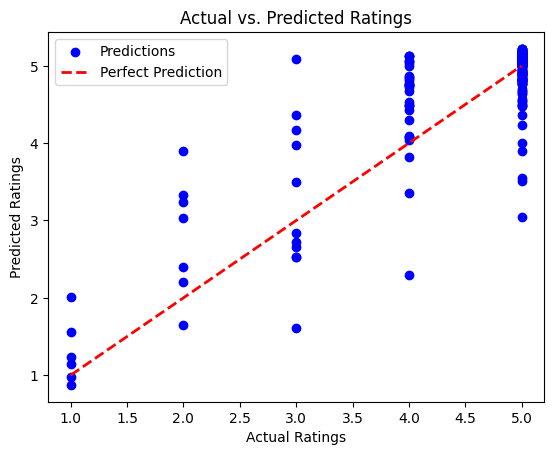

In [14]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

test_folder = "Dataset/test_data.csv"
test_dataset = AmazonReviewsDataset(test_folder, tokenizer, max_length=256)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


model.eval()

actual_ratings_list = []
predictions_list = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        predictions = outputs.logits.squeeze().tolist()

        actual_ratings_list.extend(labels.cpu().numpy())
        predictions_list.extend(predictions)
        break

actual_ratings = np.array(actual_ratings_list)
predictions = np.array(predictions_list)

def mse_per_class(predictions, actual_ratings):
    mse_by_class = {}
    unique_ratings = np.unique(actual_ratings)

    for rating in unique_ratings:
        indices = np.where(actual_ratings == rating)
        mse = mean_squared_error(actual_ratings[indices], predictions[indices])
        mse_by_class[rating] = mse

    return mse_by_class

mse_by_class = mse_per_class(predictions, actual_ratings)

for rating, mse in mse_by_class.items():
    print(f'MSE for {rating}-star ratings: {mse}')

plt.scatter(actual_ratings, predictions, color='blue', label='Predictions')
plt.plot([min(actual_ratings), max(actual_ratings)], [min(actual_ratings), max(actual_ratings)], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.legend()
plt.show()

# Attention Mechanism Visualization

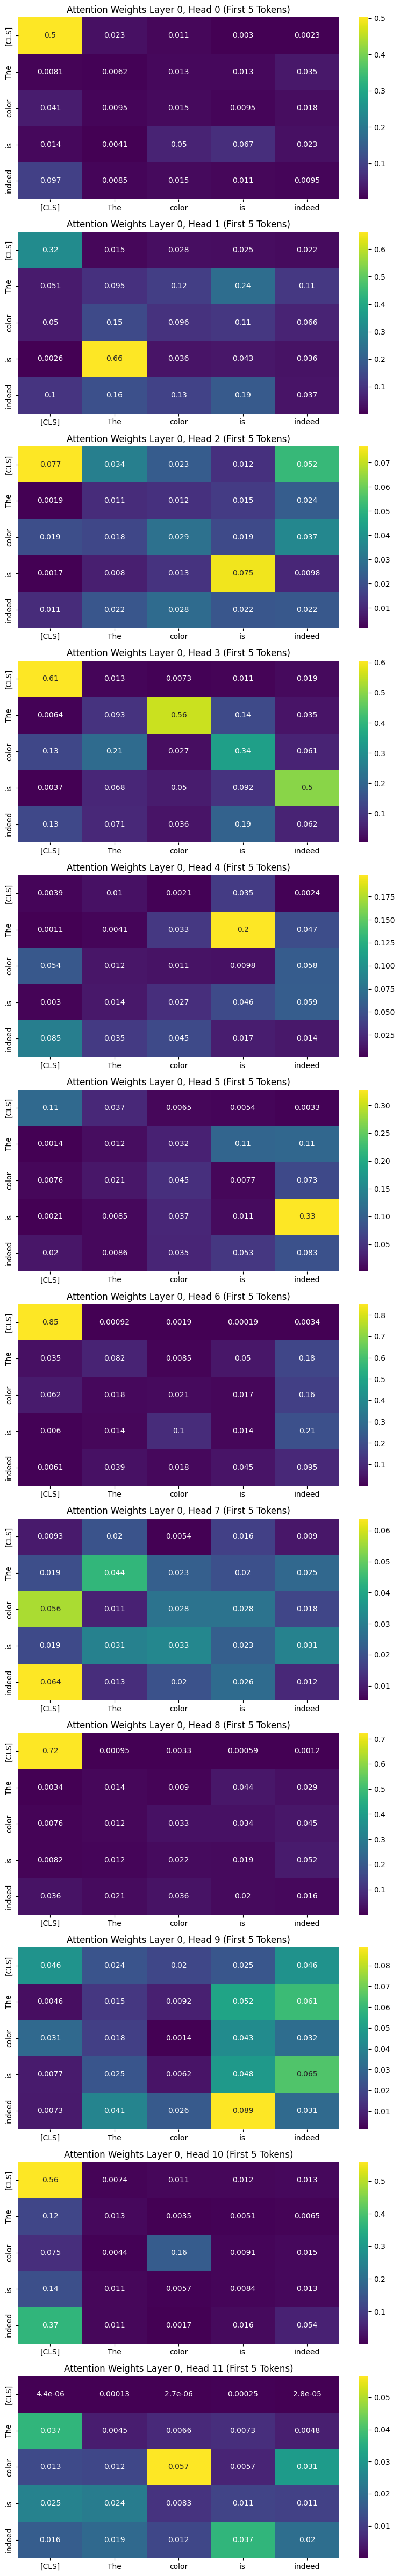

In [37]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

def get_attention_weights(model, input_ids, attention_mask, attention_layer_idx=0):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=None, output_attentions=True)

    attention_weights = [outputs.attentions[0][:,head, :5, :5] for head in range(12)]

    return attention_weights

example_index = 0
example = test_dataset[example_index]

attention_layer_idx = 1

input_ids = example['input_ids'].unsqueeze(0).to(device)
attention_mask = example['attention_mask'].unsqueeze(0).to(device)

attention_weights_list = get_attention_weights(model, input_ids, attention_mask, attention_layer_idx)

tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy()[:5])

num_layers = len(attention_weights_list)

fig, axes = plt.subplots(nrows=num_layers, ncols=1, figsize=(8, 48))

for i, attention_weights in enumerate(attention_weights_list):
    sns.heatmap(attention_weights.squeeze().detach().cpu().numpy(), cmap='viridis', xticklabels=tokens, yticklabels=tokens, annot=True, ax=axes[i])
    axes[i].set_title(f'Attention Weights Layer {0}, Head {i} (First 5 Tokens)')

plt.tight_layout()
plt.show()

In [5]:
import time

test_folder = "Dataset/test_data.csv"
test_dataset = AmazonReviewsDataset(test_folder, tokenizer, max_length=256)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model_path = "model_weights"
model = BertForSequenceClassification.from_pretrained(model_path)

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")


def measure_inference_time(model, input_ids, attention_mask):
    start_time = time.time()
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0), labels=None, output_attentions=False)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

input_data = test_dataset[0]
input_ids = input_data['input_ids']
attention_mask = input_data['attention_mask']
inference_time = measure_inference_time(model, input_ids, attention_mask)
print(f"Inference Time: {inference_time} seconds")


Inference Time: 2.339254856109619 seconds


In [7]:
def get_model_size(model):
    model_size_bytes = os.path.getsize('model_weights/model.safetensors')
    return model_size_bytes

model_size_bytes = get_model_size(model)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"Model Size: {model_size_mb} MB")


Model Size: 413.1962699890137 MB
